# Lab 7: Pitch tracking and modifications

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from numpy import conj
from numpy.fft import rfft, irfft, fftshift

## Part 1: Making a pitch tracker

In this section we will design a pitch tracker. We will apply it on this sound file:

[https://drive.google.com/uc?export=download&id=1gB1MlHQJiXRJRYAauWxdJDcRoYs8q0oM ]

We want to find the pitch of the singing over time, as well as if the sound is pitched or not at any point in time. To do so we will design an autocorrelation pitch tracker.
Do the following:
1. Perform an STFT of the sound
2. Using the DFT representation of each frame compute the frame’s autocorrelation
3. Invert each frame’s autocorrelation back to the time domain
4. Find the first peak after the main peak (which will be at the first element)
    - We will only look for pitches between 100 and 300Hz
	- Which means that you only need to look for a peak at a specific range
5. If the peak is more than 70% of the main peak we have a pitched frame
	- Otherwise it is an un-pitched frame
Plot the pitch value over time and see if it correlates with what you are hearing (we also have the correct plot in the lecture slides).


In [2]:
# YOUR CODE HERE
# raise NotImplementedError()
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

def get_stft(x, dft_size=512, hop_size=512, zero_pad=0, window='hanning'):
    # YOUR CODE HERE
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    L = len(x)
    num_frame = (L-dft_size)//hop_size
    tail = L-(num_frame*hop_size+dft_size)
    if tail>0:
        pad = hop_size-tail
        x = np.pad(x, (0,pad), 'constant')
        num_frame += 1
    stft = np.zeros((num_frame, int((dft_size+zero_pad)/2)+1)).astype(complex)
    for i, t in enumerate(stft[:]):
        input_f = x[i*hop_size:i*hop_size+dft_size].astype(float)
        input_f *= w(len(input_f))
        input_f = np.pad(input_f, (0, zero_pad), 'constant')    
        stft[i] = np.fft.rfft(input_f)
    stft = stft.T
    # Return padded input sound and a complex-valued spectrogram (frequencies x time)
    return stft

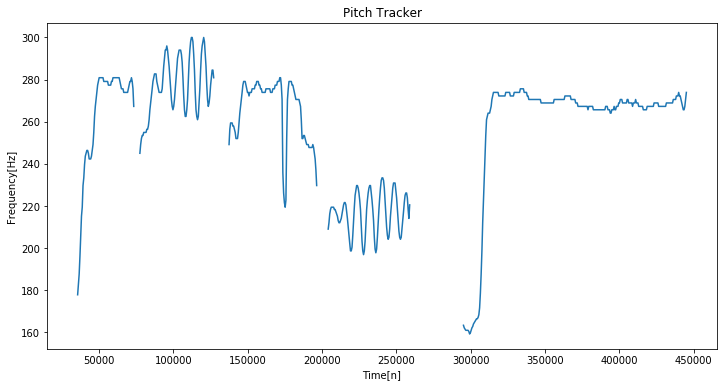

In [3]:
fname = 'beauty.wav'
fs, data = read(fname)
stft = get_stft(data, dft_size=4096, hop_size=512)
lb = int(fs/300)
hb = int(fs/100)
p = []
for t in range(stft.shape[1]):
    c = irfft(stft[:, t] * conj(stft[:, t]))
    if np.max(c[lb:hb])<=0.7*c[0]:
        p.append(np.nan)
        continue
    else:
        for b in range(lb, hb):
            if c[b]==np.max(c[b-50:b+50]):
                p.append(b)
                break
        continue
p = np.array(p)
x = np.arange(len(p.reshape(-1)))
x = np.linspace(0, len(data), len(x))
y = fs/(p[p!=np.nan].reshape(-1))
plt.figure(figsize=(12,6))
plt.xticks(np.arange(0, 500000, 50000))
plt.yticks(np.arange(100, 350, 20))
plt.xlabel('Time[n]')
plt.ylabel('Frequency[Hz]')
plt.title('Pitch Tracker')
plt.plot(x, y, markersize=3);

## Part 2. Changing pitch 

We will now correct the pitch of that last horrible note. We will use the zero crossing method to find where the periods are and then we will shift them appropriately to create a pitch of 274Hz.

1. Get samples 303,000 to 445,000 which is the horrible part.

2. Lowpass filter to facilitate the zero crossing finding

    - Pick an appropriate cutoff frequency that will help
    – Use the ```scipy.signal.filtfilt()``` function which will not time-shift the input
    
3. Find the zero crossing points which should be the starts of each period

4. For each period get the signal from the previous period’s start till this period’s end

5. Window that signal with a Hann window to remove any discontinuities

6. Overlap add each of the above at a rate appropriate for 274Hz

Play the sound, does it sound more in tune? (it better!)

In [4]:
# YOUR CODE HERE
# raise NotImplementedError()
fs, data = read(fname)
data = data.astype(float)
from scipy import signal

# get horrible data
horrible_data = np.array(data[303000:445000]).astype(float)

# apply lowpass filter
b, a = signal.butter(13, 2000, 'lowpass', fs=fs)
filtered_data = signal.filtfilt(b, a, horrible_data)

# get zero crossings
zero_crossing = []
for i in range(len(filtered_data)-1):
    if filtered_data[i] * filtered_data[i+1] < 0:
        zero_crossing.append(i)
        
# apply overlap-add to shift pitch
ola_offset = int(fs/274/2)
tuned_data = np.zeros(len(filtered_data))
for i in range(len(zero_crossing)-3):
    start, end = zero_crossing[i], zero_crossing[i+3]
    f = np.array(horrible_data[start:end]) # a frame containing 4 zero crossings
    f *= np.hanning(len(f))
    if i*ola_offset+len(f)<=len(tuned_data):
        tuned_data[i*ola_offset:i*ola_offset+len(f)] += f
    else: # last frame
        tuned_data[i*ola_offset:] += f[:len(tuned_data[i*ola_offset:])]
sound(data, fs, 'beauty')
data[303000:445000] = tuned_data
sound(data, fs, 'tuned beauty')

beauty


tuned beauty
